In [163]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [164]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)

In [165]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [166]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

# Reddit Subreddit API analysis

Subreddit Stats
+----------------------+-------+------------+-------------+----------------------+-----------------+
|         name         | index | Unnamed: 0 | subscribers |     display_name     | subscribers_pct |
+----------------------+-------+------------+-------------+----------------------+-----------------+
|       chatgpt        |   7   |     7      |   4491408   |       chatgpt        |      36.51      |
|   machinelearning    |   4   |     4      |   2870084   |   MachineLearning    |      23.33      |
|     datascience      |   8   |     8      |   1362754   |     datascience      |      11.08      |
|        openai        |   5   |     5      |   1120060   |        OpenAI        |       9.11      |
|         gpt3         |   2   |     2      |    720336   |         GPT3         |       5.86      |
|      artificial      |   6   |     6      |    718553   |      artificial      |       5.84      |
| learnmachinelearning |   11  |     11     |    384248   | learnmachinelea

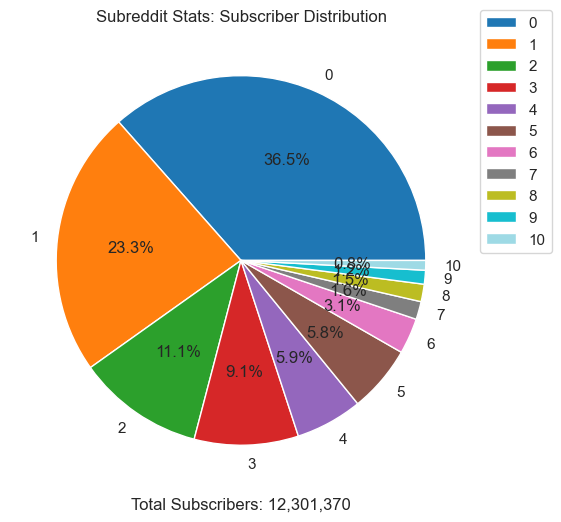

In [167]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('./output/**/*.meta'), recursive=True):
    _metadata = pd.read_csv(fname)
    metadata = metadata.append(_metadata.copy())
    #print(fname)
    #break #DEBUG

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata.columns
# Add rows to the table
for row in metadata.itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(metadata)))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=colors)
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(metadata['subscribers'].sum()))
plt.show()

# Reddit Search API data analysis

In [168]:
# Reddit data structure
topics_dict_template = {"subreddit":[],
                        "query":[],
                        "sort":[],
                        "date":[],
                        "title":[],
                        "author":[],
                        "stickied":[],
                        "upvote_ratio":[],
                        "score":[],
                        "id":[],
                        "url":[],
                        "num_comments": [],
                        "created": [],
                        "body":[]}

# Import query data
df = {}
running_total = 0
for fname in glob.glob(os.path.abspath('./output/**/*.csv'), recursive=True):
    filename = os.path.splitext(os.path.basename(fname))[0]
    _df=pd.read_csv(fname)
    df[filename] = pd.DataFrame(_df)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

print(f"Total imported Reddit posts: {running_total}")

Total imported Reddit posts: 1528


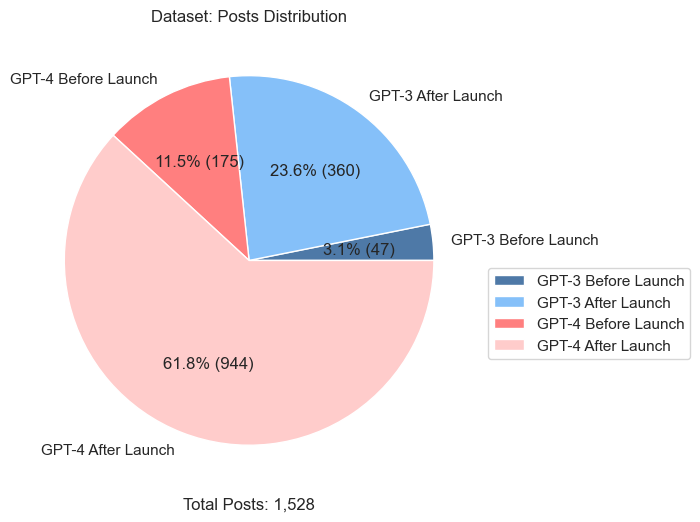

In [169]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_launch = datetime(2022, 11, 30)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# Split at gpt3_launch date
df_gpt3_before = df['gpt3-before']
df_gpt3_after = df['gpt3-after']
# Split at gpt4_launch date
df_gpt4_before = df['gpt4-before']
df_gpt4_after = df['gpt4-after']

# Get counts of datasets before and after launch dates
df_gpt_counts = {
    'GPT-3 Before Launch': len(df_gpt3_before),
    'GPT-3 After Launch': len(df_gpt3_after),
    'GPT-4 Before Launch': len(df_gpt4_before),
    'GPT-4 After Launch': len(df_gpt4_after)
}
# Plot pie chart of GPT search distribution
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#85c0f9', '#ff7f7f', '#ffcccb']  
plt.pie(df_gpt_counts.values(), colors=colors, labels=df_gpt_counts.keys(), autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(df_gpt_counts.values()))})")
# Add annotations for subscriber percentages
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Dataset: Posts Distribution')
plt.ylabel('')
plt.xlabel('Total Posts: ' + "{:,}".format(sum(df_gpt_counts.values())))
plt.show()

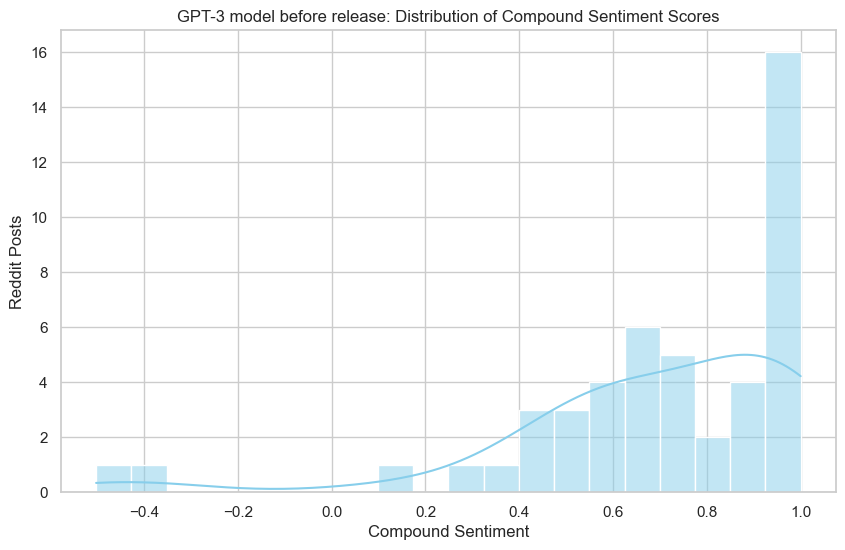

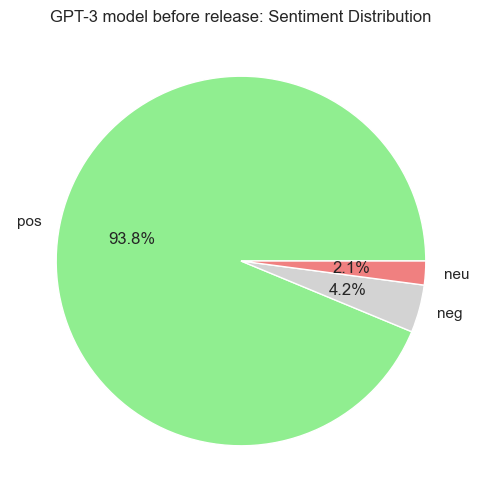

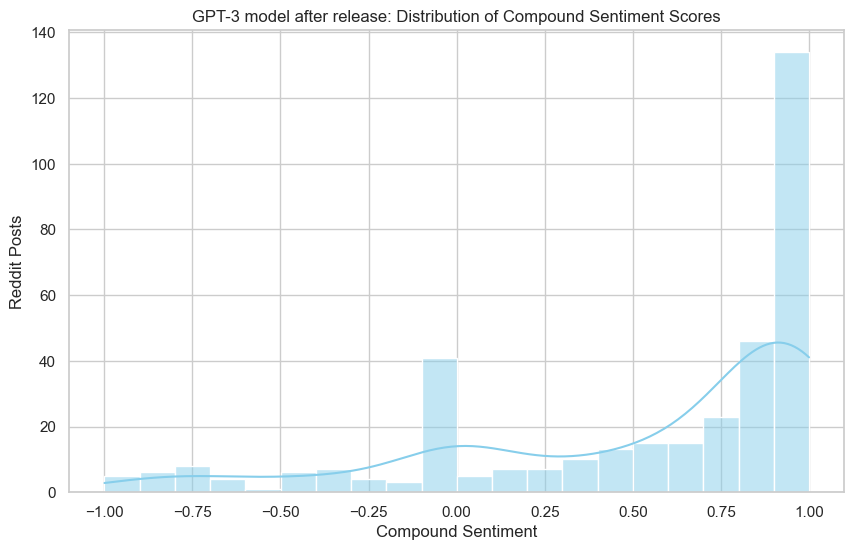

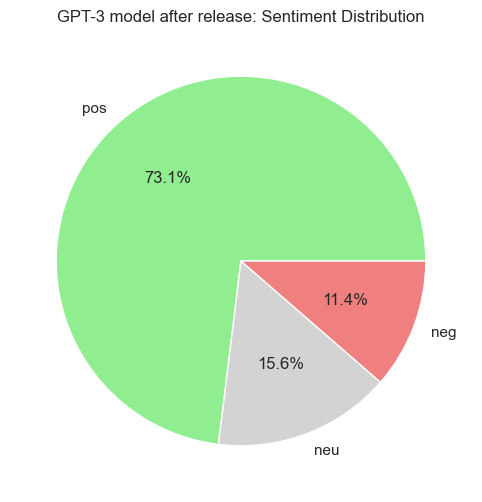

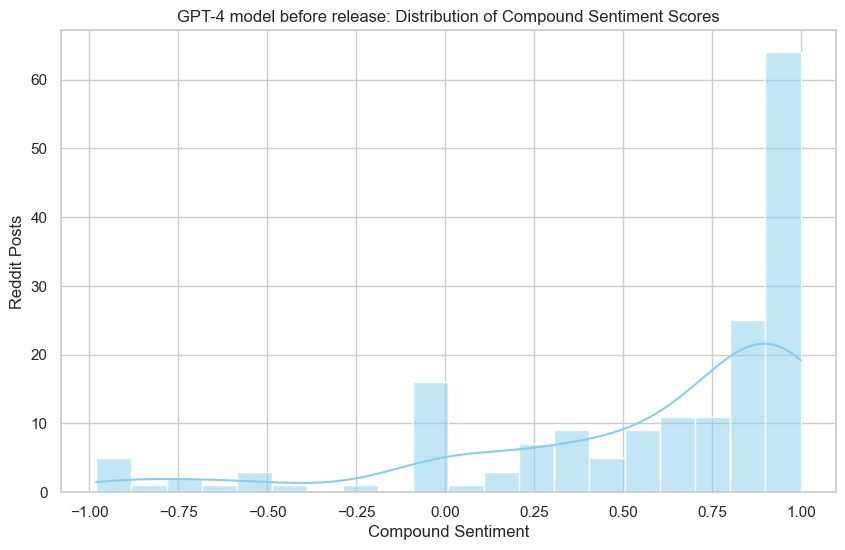

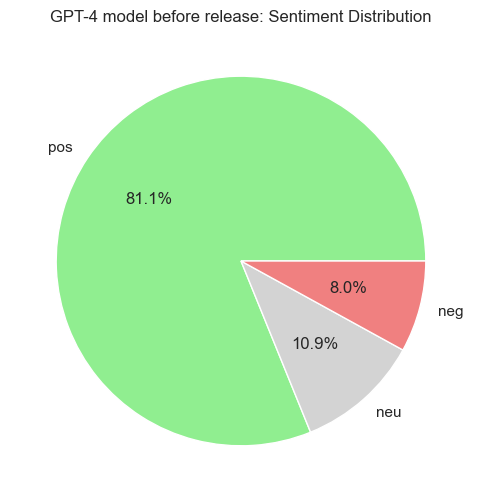

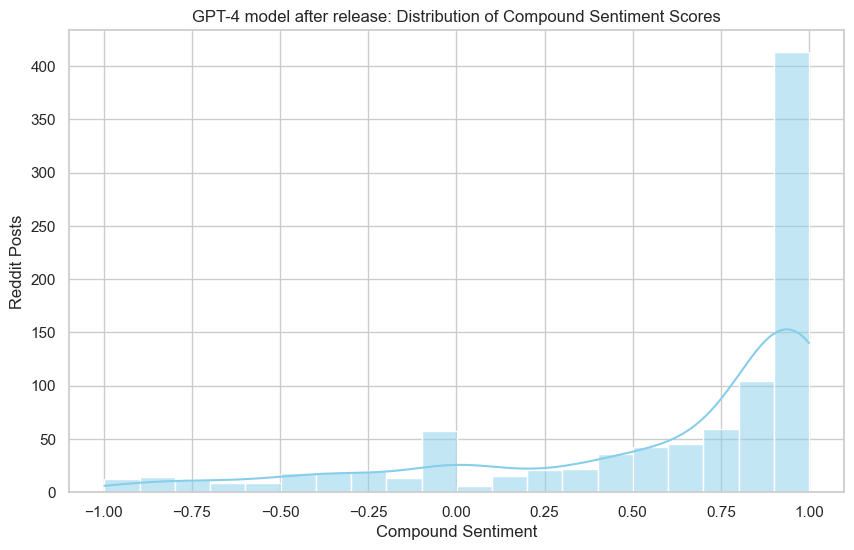

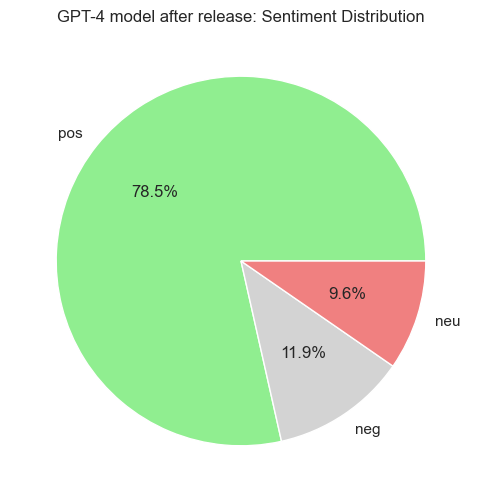

In [170]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3_before, name='GPT-3 model before release')
visualize_sentiment(dataset=df_gpt3_after, name='GPT-3 model after release')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before release')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after release')

# Preparing datasets, features, and targets

In [171]:
# Features to measure with MLflow
feature_names = ['launch_distance_f', 'num_comments_weighted', 'stickied', 'upvote_ratio', 'created', 'compound', 'pos', 'neg', 'neu']
# Target MLflow value
target_name = 'score_weighted'
# these variables should be represented as log of the original values
log_variables = ['score_weighted','num_comments', 'launch_distance_f', 'num_comments_weighted']

for variable in log_variables:
    # Rename the variables to log_[variable] in the datasets
    log_variable = 'log_'+variable
    if target_name == variable:
        target_name = log_variable
    elif variable in feature_names:
        feature_names[feature_names.index(variable)] = log_variable


# These features are disabled. Stickied items throw off the counts.
for feature in ['stickied', 'created', 'pos', 'neg', 'neu']: feature_names.remove(feature)

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['log_launch_distance_f', 'log_num_comments_weighted', 'upvote_ratio', 'compound']
target_name=log_score_weighted


In [172]:
def describe_dataset(dataset, name):
    print(name)
    description_table = dataset.describe()

    # Convert the 'created' column to datetime
    description_table['created'] = pd.to_datetime(description_table['created'], unit='s')

    description_table = description_table.transpose()
    description_table.reset_index(inplace=True)

    # Create a PrettyTable object for the first half of columns
    table1 = PrettyTable()
    table1.field_names = description_table.columns[:1+len(description_table.columns)//2]

    # Create a PrettyTable object for the second half of columns, including the first column
    table2 = PrettyTable()
    table2.field_names = ['index'] + list(description_table.columns[1+len(description_table.columns)//2:])

    # Set the float format for all float columns
    float_format = "{:.2f}"

    # Set the timedelta format
    def format_timedelta(td):
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days" # {hours:02}:{minutes:02}:{seconds:02}
    
    # Format date
    def format_date(dt):
        return dt.strftime("%Y-%m-%d") # %H:%M:%S

    # Add rows to the tables
    for row in description_table.itertuples(index=False):
        # Convert timedelta values to formatted strings
        row = list(row)
        for i, value in enumerate(row):
            if isinstance(value, pd.Timedelta):
                row[i] = format_timedelta(value)
            elif isinstance(value, pd.Timestamp):
                row[i] = format_date(value)
        # Format float values
        row = [float_format.format(value) if isinstance(value, float) else value for value in row]
        # Add row to the first table
        table1.add_row(row[:1+len(description_table.columns)//2])
        # Add row to the second table
        table2.add_row([row[0]] + row[1+len(description_table.columns)//2:])

    # Print the tables
    print(table1)
    print(table2)

describe_dataset(dataset=df_gpt3_before, name='GPT-3 model before release')
describe_dataset(dataset=df_gpt3_after, name='GPT-3 model after release')
describe_dataset(dataset=df_gpt4_before, name='GPT-4 model before release')
describe_dataset(dataset=df_gpt4_after, name='GPT-4 model after release')

GPT-3 model before release
+---------------------------+------------+------------+------------+------------+
|           index           |   count    |    mean    |    std     |    min     |
+---------------------------+------------+------------+------------+------------+
|           index           |   48.00    |  4229.77   |  1655.79   |   182.00   |
|         Unnamed: 0        |   48.00    |   59.29    |   43.12    |    1.00    |
|        upvote_ratio       |   48.00    |    0.86    |    0.16    |    0.50    |
|           score           |   48.00    |   45.90    |   96.08    |    0.00    |
|        num_comments       |   48.00    |   20.00    |   38.09    |    0.00    |
|          created          | 1970-01-01 | 2022-11-16 | 1970-01-09 | 2022-11-01 |
|       score_weighted      |   48.00    |   56.55    |   124.30   |    0.00    |
|   num_comments_weighted   |   48.00    |   23.60    |   47.86    |    0.00    |
|     launch_distance_f     |   48.00    |   13.85    |    8.73    |   

# Run MLflow experiment
Linear regression analysis. Remove "stickied" Reddit posts from data.

Test model against data after GPT-4 launch.

In [173]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = .1, q_upper = .9):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _dataset = _dataset[(_dataset['stickied'] == False)]
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] >= _q_lower) &
                        (_dataset[quantile] <= _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

gpt3_model = model_testing(df_gpt3_before, df_gpt3_after)
gpt4_model = model_testing(df_gpt4_before, df_gpt4_after)

In [174]:
print(pd.DataFrame(gpt3_model['y_pred']).describe())
print(pd.DataFrame(gpt3_model['X']).describe())
print(pd.DataFrame(gpt3_model['coef']))

                0
count  324.000000
mean     1.786619
std      1.302849
min     -2.012315
25%      1.009346
50%      1.823082
75%      2.745084
max      4.853825
       upvote_ratio   compound  log_launch_distance_f  \
count     39.000000  39.000000              39.000000   
mean       0.883333   0.689585               2.368281   
std        0.129905   0.297312               0.903516   
min        0.580000  -0.502300               0.092360   
25%        0.795000   0.552600               1.903971   
50%        0.930000   0.713000               2.504178   
75%        1.000000   0.937100               3.097260   
max        1.000000   0.999900               3.380246   

       log_num_comments_weighted  
count                  39.000000  
mean                    1.960717  
std                     1.284752  
min                     0.000000  
25%                     0.709140  
50%                     2.282523  
75%                     2.774500  
max                     4.919700  
         

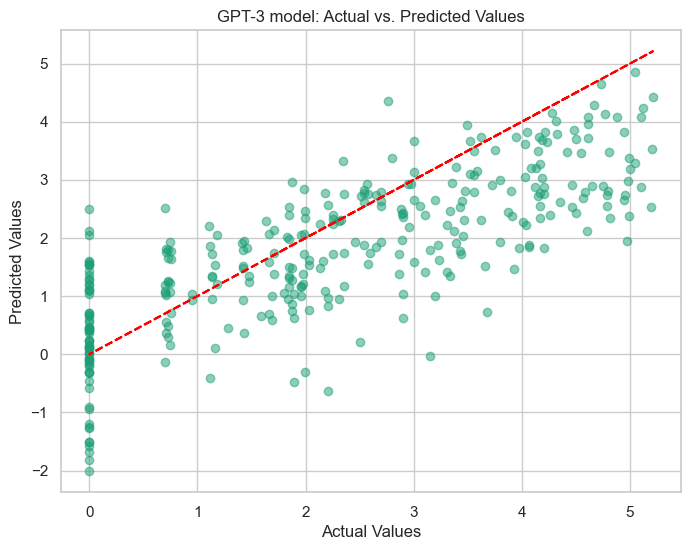

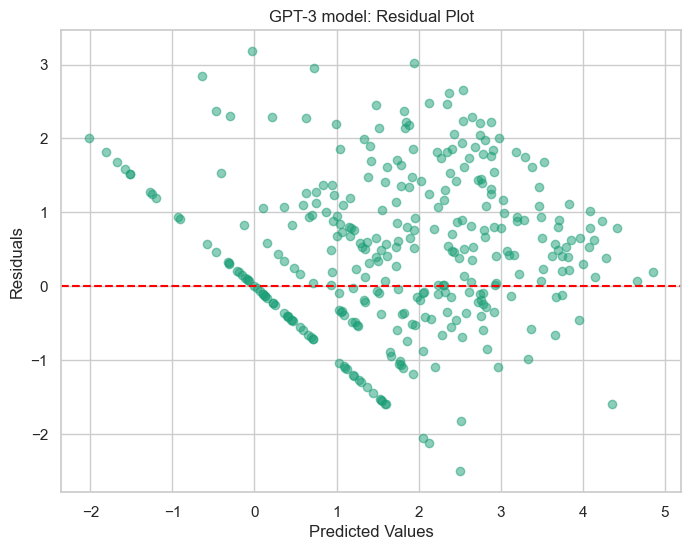

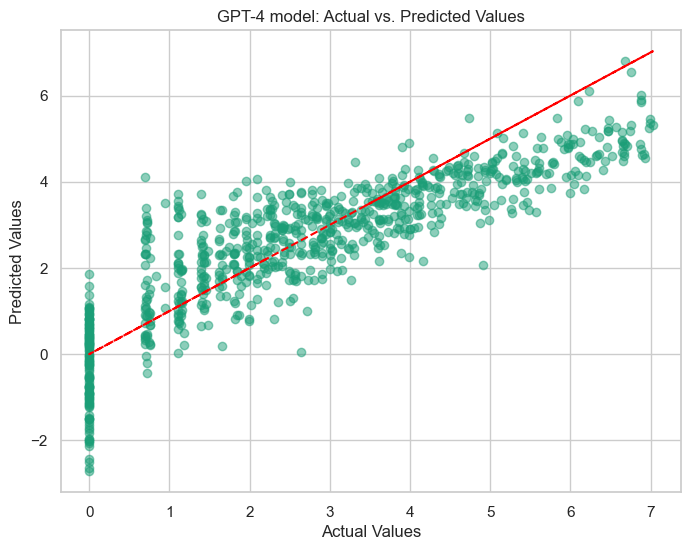

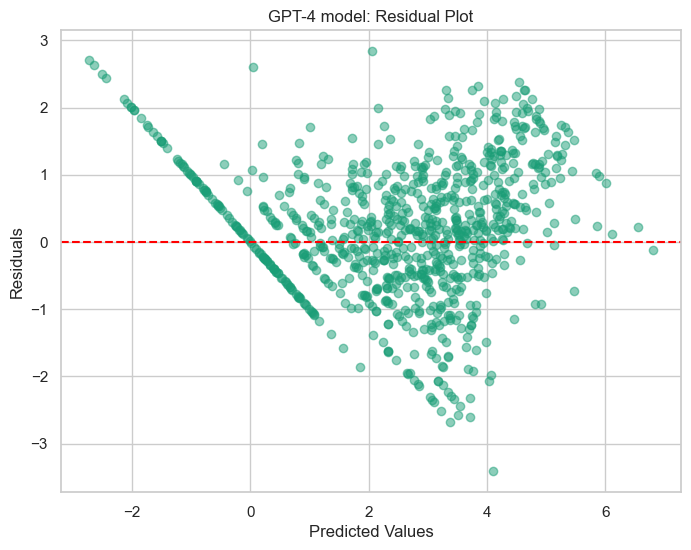

In [175]:
# Plot accuracy of the models
def plot_accuracy(model, name):
    actual_values = model['y_actual']
    predicted_values = model['y_pred']

    # Scatter plot of actual versus predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name + ": Actual vs. Predicted Values")
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = actual_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(name + ": Residual Plot")
    plt.grid(True)
    plt.show()

    # Coefficient plot (if coefficients are available in the MLflow run)
    if "coefficients" in model:
        coefficients = model["coef"]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=coefficients.index, y=coefficients.values)
        plt.xlabel("Independent Variables")
        plt.ylabel("Coefficients")
        plt.title("Coefficient Plot")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
plot_accuracy(model=gpt3_model, name='GPT-3 model')
plot_accuracy(model=gpt4_model, name='GPT-4 model')

# Feature Plots

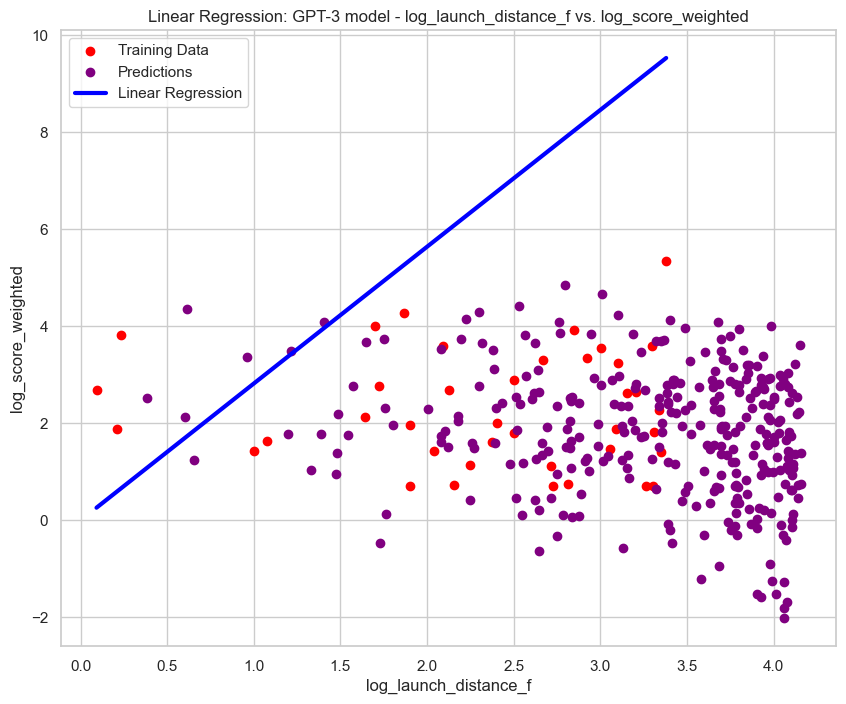

log_launch_distance_f=2.819208793256901


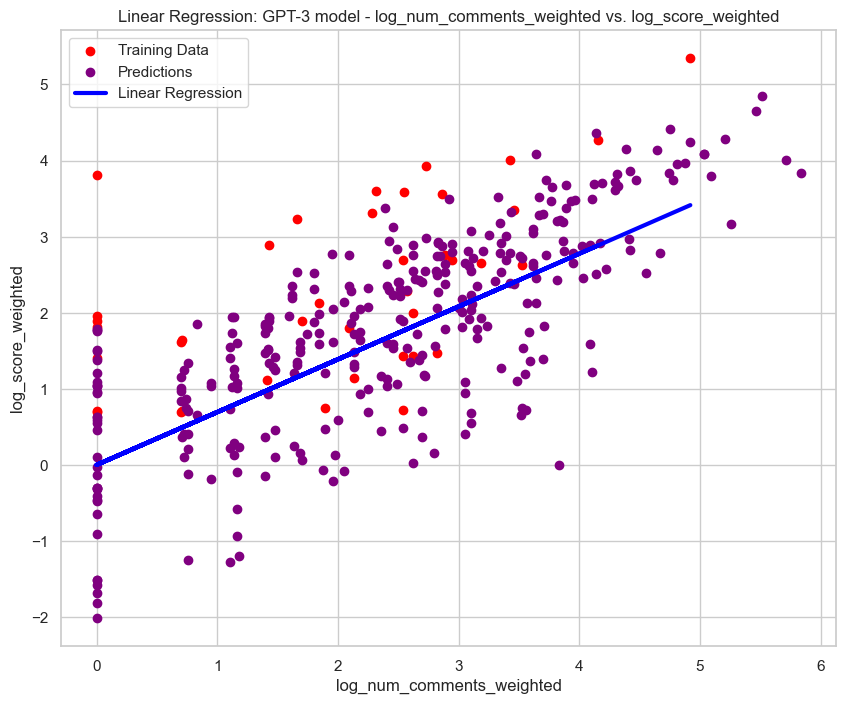

log_num_comments_weighted=0.6939498475361515


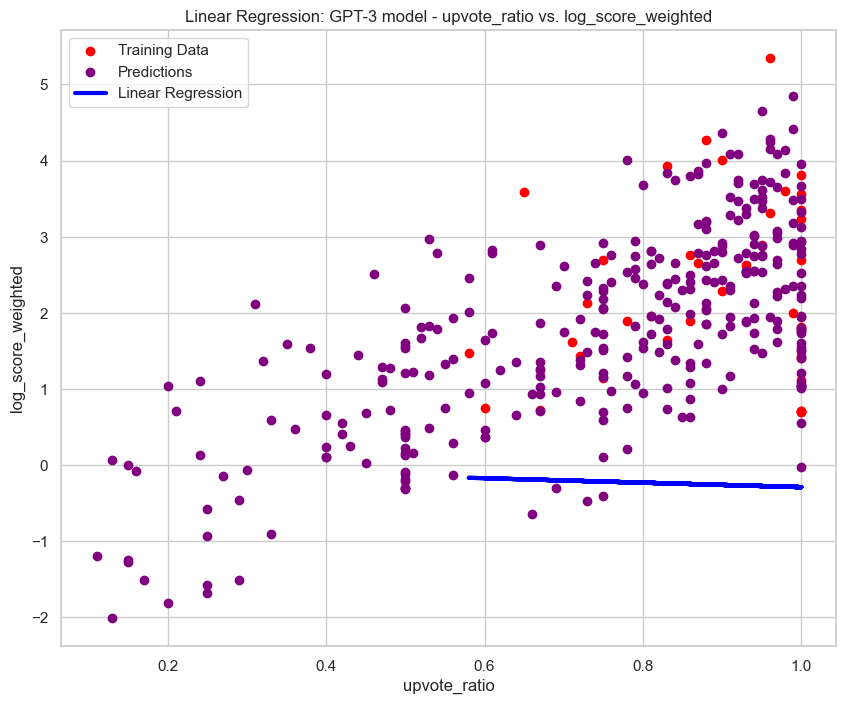

upvote_ratio=-0.2926066195264845


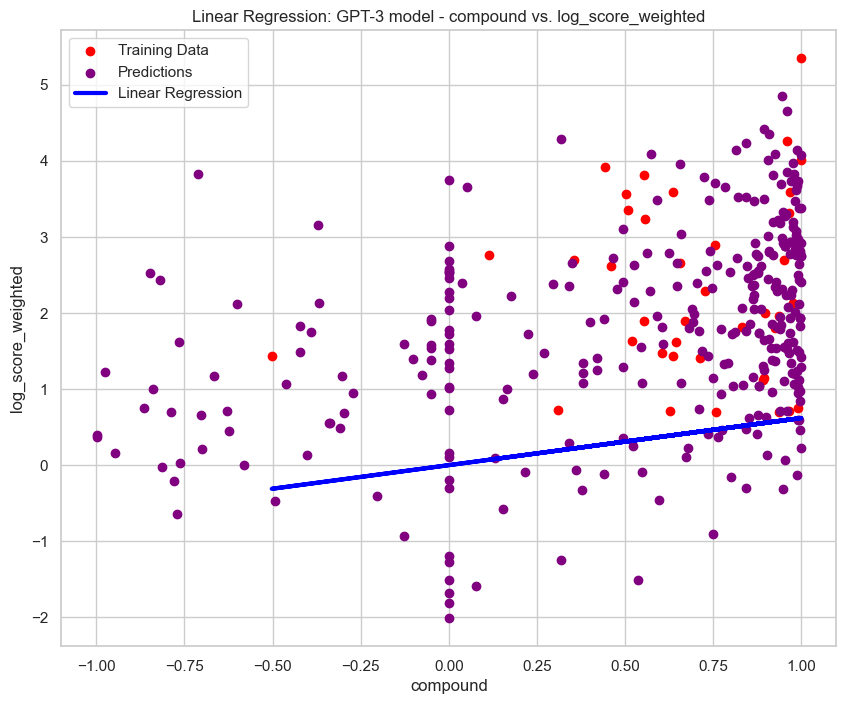

compound=0.6192357416001413


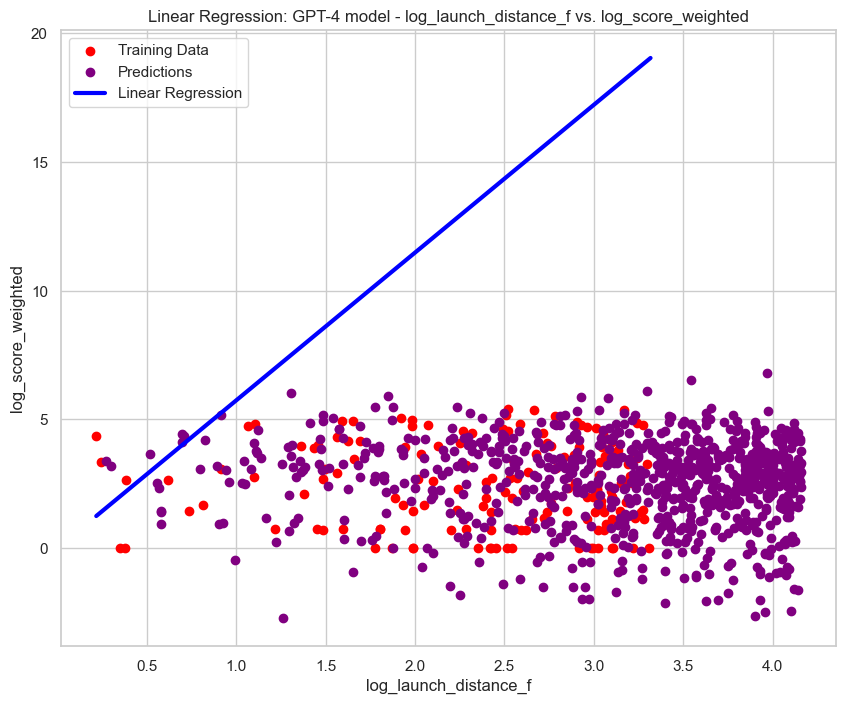

log_launch_distance_f=5.738450974079754


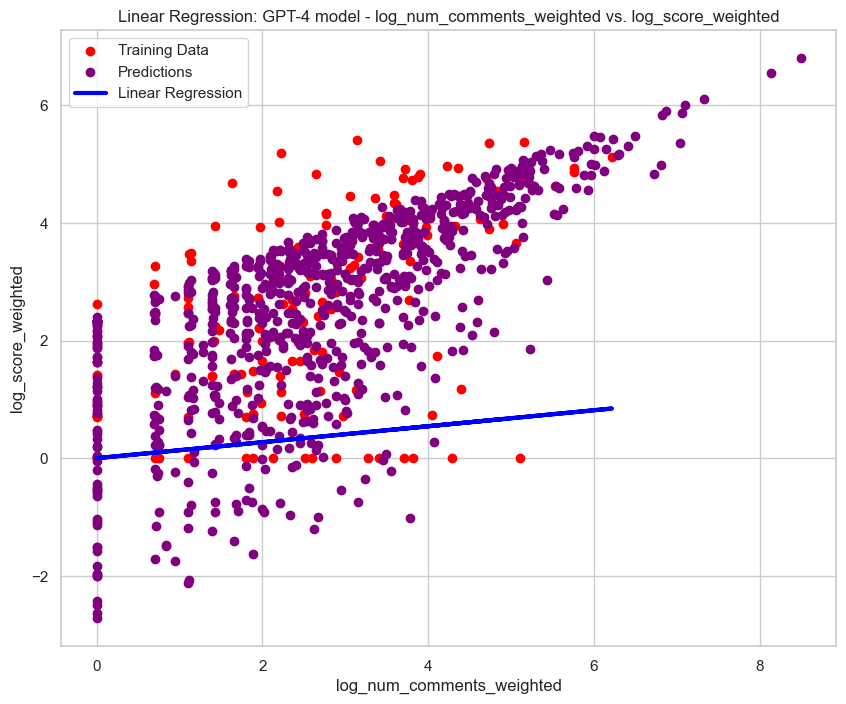

log_num_comments_weighted=0.1357875789519869


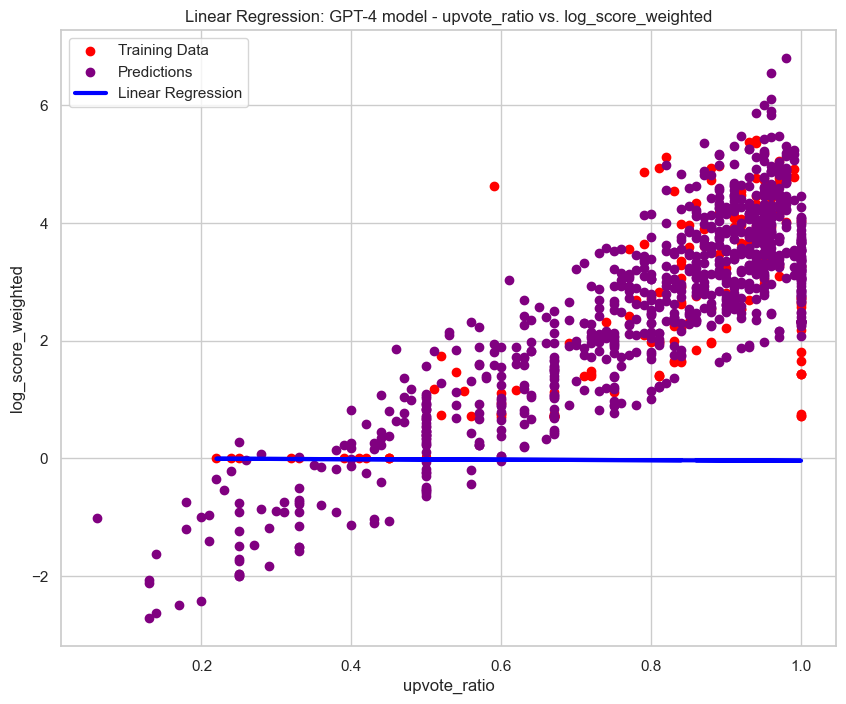

upvote_ratio=-0.04251935799656908


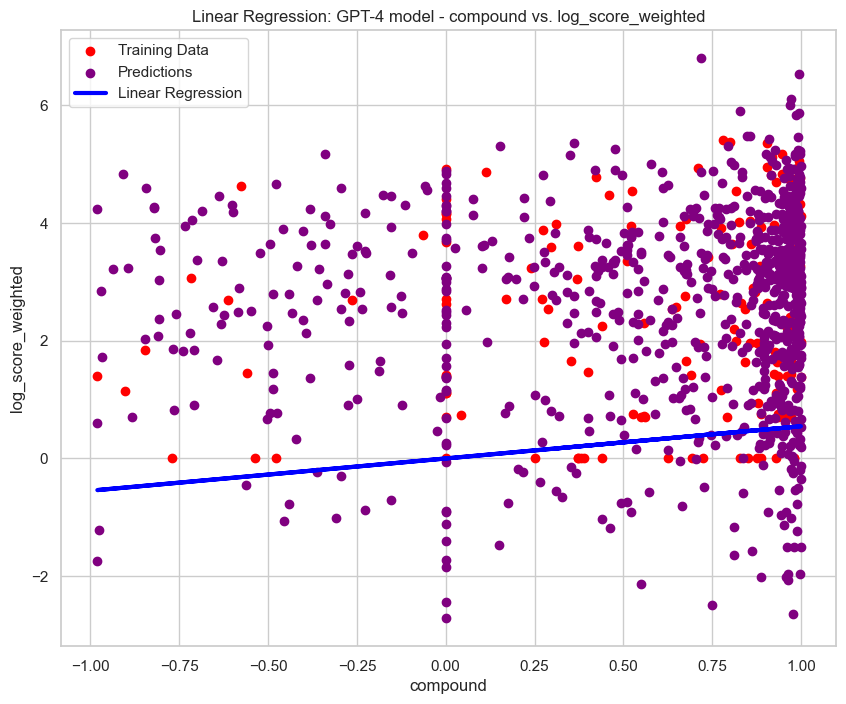

compound=0.5480933096354259


In [176]:
def plot_features(model, name):
    for coef in feature_names:
        feature = coef
        plt.scatter(model['X'][feature], model['y'], color='red', label='Training Data')
        plt.scatter(model['X_test'][feature], model['y_pred'], color='purple', label='Predictions')
        y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
        plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3, label='Linear Regression')
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{target_name}")
        plt.title(f"Linear Regression: {name} - {feature} vs. {target_name}")
        plt.legend()
        plt.show()
        print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
plot_features(model=gpt3_model, name='GPT-3 model')
plot_features(model=gpt4_model, name='GPT-4 model')

# Categorical Distributions

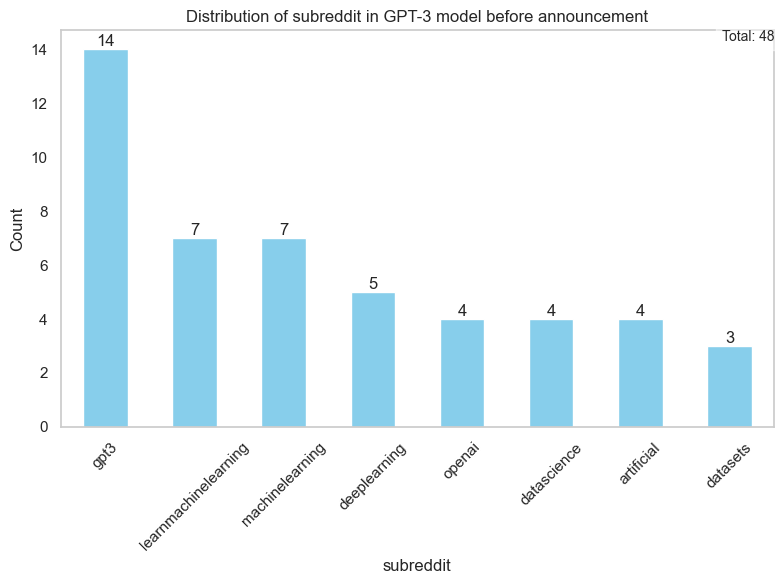

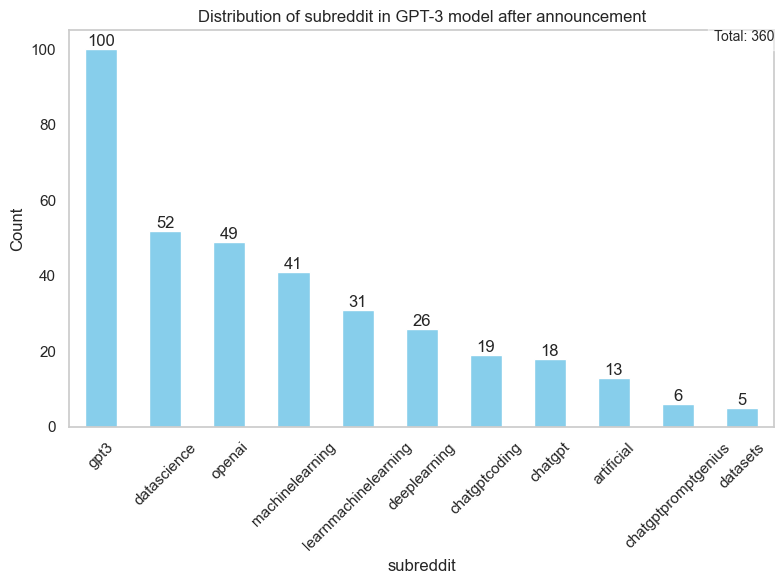

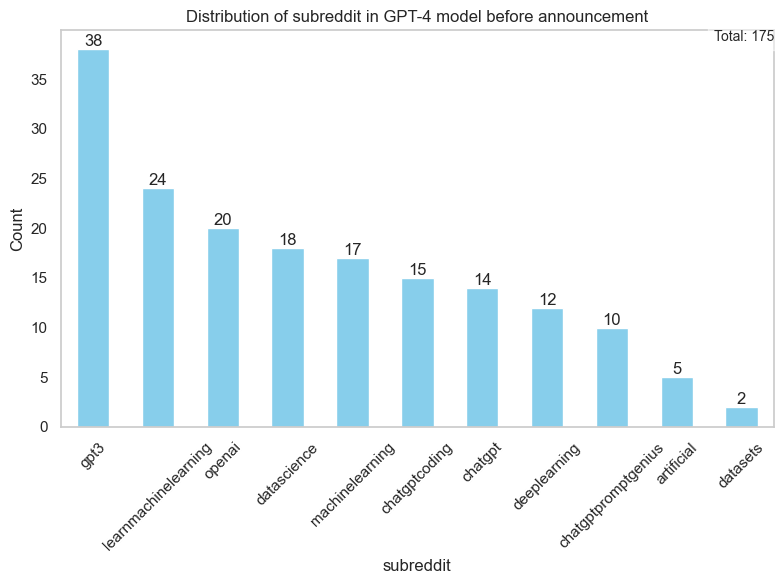

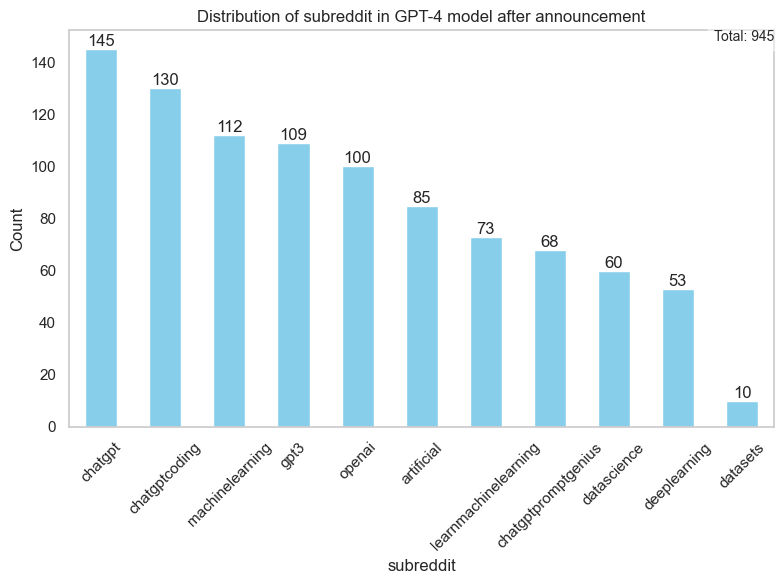

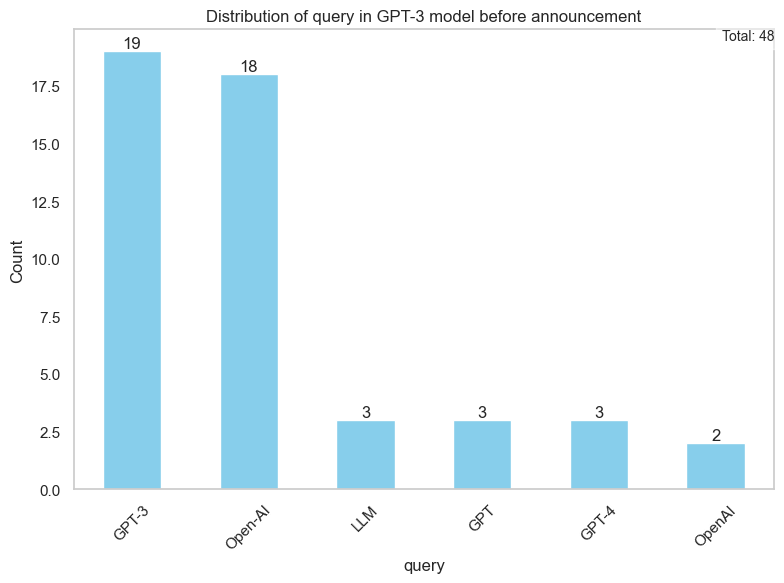

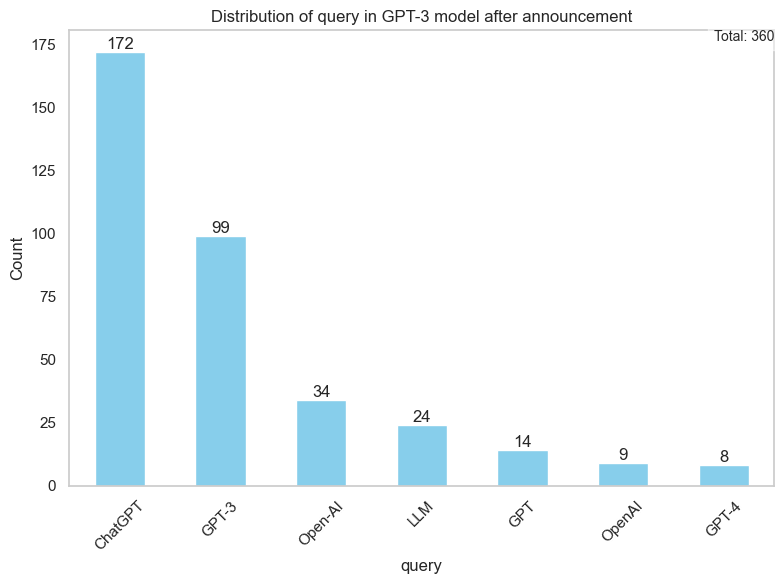

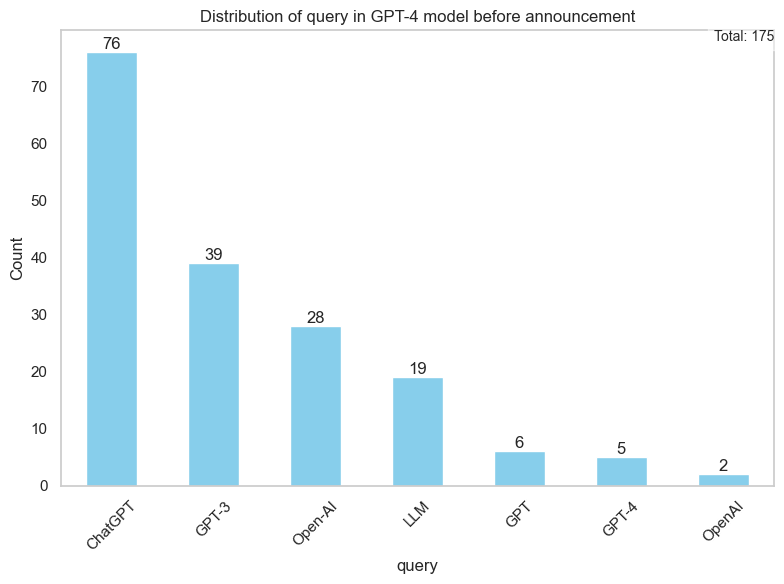

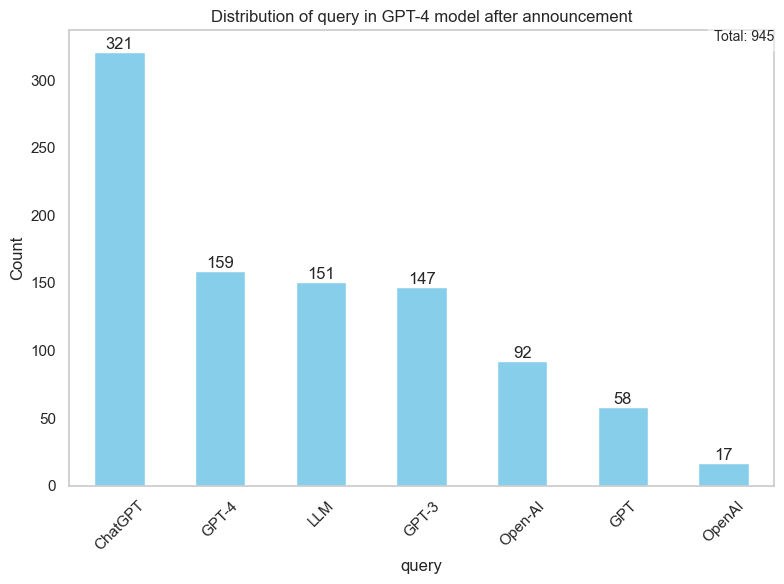

In [177]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3_before, name='GPT-3 model before announcement', category=category)
    plot_distributions(dataset=df_gpt3_after, name='GPT-3 model after announcement', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)

# Heatmap of MLflow runs

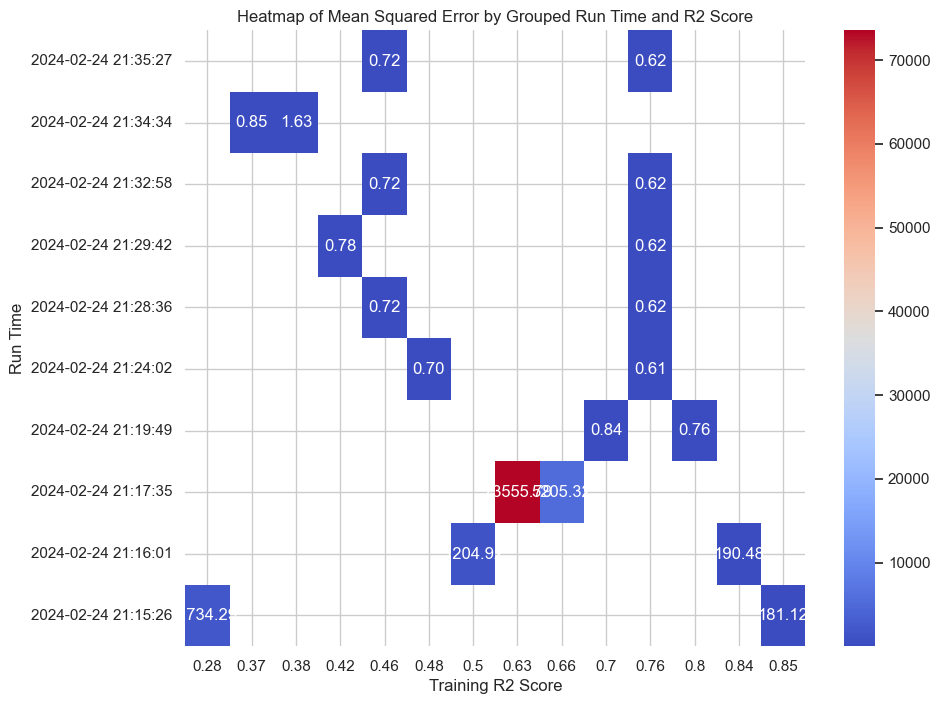

In [178]:
# Fetch the data from MLflow
experiments = mlflow.search_runs()

# Convert 'start_time' column to datetime
experiments['start_time'] = pd.to_datetime(experiments['start_time'])
# Format 'start_time' to include date, hour, minute, and second
experiments['start_time'] = experiments['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Trim the values in 'metrics.training_r2_score' to two decimal places
experiments['metrics.training_r2_score'] = experiments['metrics.training_r2_score'].apply(lambda x: round(x, 2))

# Sort by 'start_time' column in descending order
experiments_sorted = experiments.sort_values(by='start_time', ascending=False)

# Take every 4 experiments and collate them
experiments_sorted['start_time_grouped'] = experiments_sorted.groupby(experiments_sorted.index // 2)['start_time'].transform(lambda x: x.iloc[0])

# Take the most recent 5 experiments
num_experiments = 10
recent_experiments = experiments_sorted.head(num_experiments*2)

# Organize the data into a DataFrame
heatmap_data = recent_experiments.pivot_table(index='start_time_grouped', columns='metrics.training_r2_score', values='metrics.training_mean_squared_error')

# Sort the index in descending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Squared Error by Grouped Run Time and R2 Score')
plt.xlabel('Training R2 Score')
plt.ylabel('Run Time')
plt.show()